# Radiotelescope - CBN observation

In [1]:
# Mostra todos os resultados da célula, não apenas o último
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"
# Truque para consertar caminhos do jupyter: variável __file__ não é definida em IPYTHON.
import project_path
import logging
import os
import sys
from matplotlib.colors import LogNorm
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.path.split(os.getcwd())[0])))
sys.path.append(os.path.abspath(os.path.join(os.path.split(os.getcwd())[0], "radiotelescope")))
sys.path.append(os.path.abspath(os.path.join(os.path.split(os.getcwd())[0], "radiotelescope/GNURadio")))
from radiotelescope.observations.observations import Observations as Obs
from radiotelescope.instruments import RTLSDRGNU
from radiotelescope.observations.observations import RFI_filter, plot_mosaic
logger = logging.getLogger("radiotelescope")
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

Para observações conecte o dongle na porta USB local.


In [2]:
sys.path

['/home/lbarosi/BAROSI/HOME/6000_PYTHONIA/2_Doing/radiotelescope/notebooks',
 '/opt/miniconda3/envs/gnuradio310/lib/python310.zip',
 '/opt/miniconda3/envs/gnuradio310/lib/python3.10',
 '/opt/miniconda3/envs/gnuradio310/lib/python3.10/lib-dynload',
 '',
 '/home/lbarosi/.local/lib/python3.10/site-packages',
 '/opt/miniconda3/envs/gnuradio310/lib/python3.10/site-packages',
 '/opt/miniconda3/envs/gnuradio310/lib/python3.10/site-packages/CallistoLinux-1.0.0-py3.10.egg',
 '/home/lbarosi/BAROSI/HOME/6000_PYTHONIA/2_Doing',
 '/home/lbarosi/BAROSI/HOME/6000_PYTHONIA/2_Doing/radiotelescope',
 '/home/lbarosi/BAROSI/HOME/6000_PYTHONIA/2_Doing/radiotelescope/radiotelescope',
 '/home/lbarosi/BAROSI/HOME/6000_PYTHONIA/2_Doing/radiotelescope/radiotelescope/GNURadio']

## Observações HI 

### Antena

In [3]:
RTLSDRGNU.GNUScript = "GNURadio.GNUController"
RTLSDRGNU.name = "SDR_CBN"
RTLSDRGNU.controller.local_folder

'../data/raw/GNURADIO/'

In [4]:
# SKY
scan_dict = {"rtlsdr": "rtl=0", 
             "name": RTLSDRGNU.controller.local_folder + RTLSDRGNU.name,  # prefixo para salvar os arquivos.
             "vec_length": 2048,  # resolução espectral.
             "samp_rate": 2000000,  # amostragem sem perda.
             "gain": 49.6,  # fixa AGC.
             "freq": 103.5e6,  # Hidrogênio neutro
             "n_integration": 1000,  # 2s por espectro.
             "n_samples": 480,  # número de amostras por arquivo.
             "duration": 500,  # ~15min
             "csv": False, 
             "fit": True
            }
scan_dict_SKY = {**scan_dict, "mode": "59"}
scan_dict_COLD = {**scan_dict, "mode": "01"}

Apontar a corneta para altitude baixa

In [5]:
RTLSDRGNU.observe(**scan_dict_SKY)

2022-11-08 08:57:33,650 radiotelescope.backend.gnuradiobackend DEBUG    Importando módulo GNURadio.GNUController
2022-11-08 08:57:33,653 radiotelescope.backend.gnuradiobackend ERROR    Script GNURADIO não pode ser carregada.


Colocar terminação de $50 \Omega$

In [9]:
RTLSDRGNU.observe(**scan_dict_COLD)

2022-11-02 16:21:02,204 radiotelescope.backend.gnuradiobackend DEBUG    Importando módulo radiotelescope.GNURadio.GNUController
2022-11-02 16:21:02,204 radiotelescope.backend.gnuradiobackend DEBUG    Importando módulo radiotelescope.GNURadio.GNUController
2022-11-02 16:21:02,208 radiotelescope.backend.gnuradiobackend DEBUG    Testando conexão com dispositivo
2022-11-02 16:21:02,208 radiotelescope.backend.gnuradiobackend DEBUG    Testando conexão com dispositivo
2022-11-02 16:21:02,424 radiotelescope.backend.gnuradiobackend DEBUG    Iniciando GNUradio script local.
2022-11-02 16:21:02,424 radiotelescope.backend.gnuradiobackend DEBUG    Iniciando GNUradio script local.
gr-osmosdr 0.2.0.0 (0.2.0) gnuradio 3.10.3.0
built-in source types: file rtl rtl_tcp uhd hackrf bladerf rfspace airspy airspyhf soapy redpitaya 
Using device #0 Realtek RTL2838UHIDIR SN: 00000001
Found Rafael Micro R820T tuner
[R82XX] PLL not locked!
Exact sample rate is: 2000000.052982 Hz
[R82XX] PLL not locked!


Arquivo ../data/raw/GNURADIO/SDR_CBN_20221102_162103_01.fit salvo com sucesso.
Arquivo ../data/raw/GNURADIO/SDR_CBN_20221102_162914_01.fit salvo com sucesso.


## Analisando Dados

#### Corneta Baixa

In [4]:
obs = Obs(duration=pd.Timedelta(24, unit="h")).initialize()
obs.backend = RTLSDRGNU
RTLSDRGNU.name = "SDR_CBN"
obs.load_observation(extension="fit");
df_baixa = obs.data

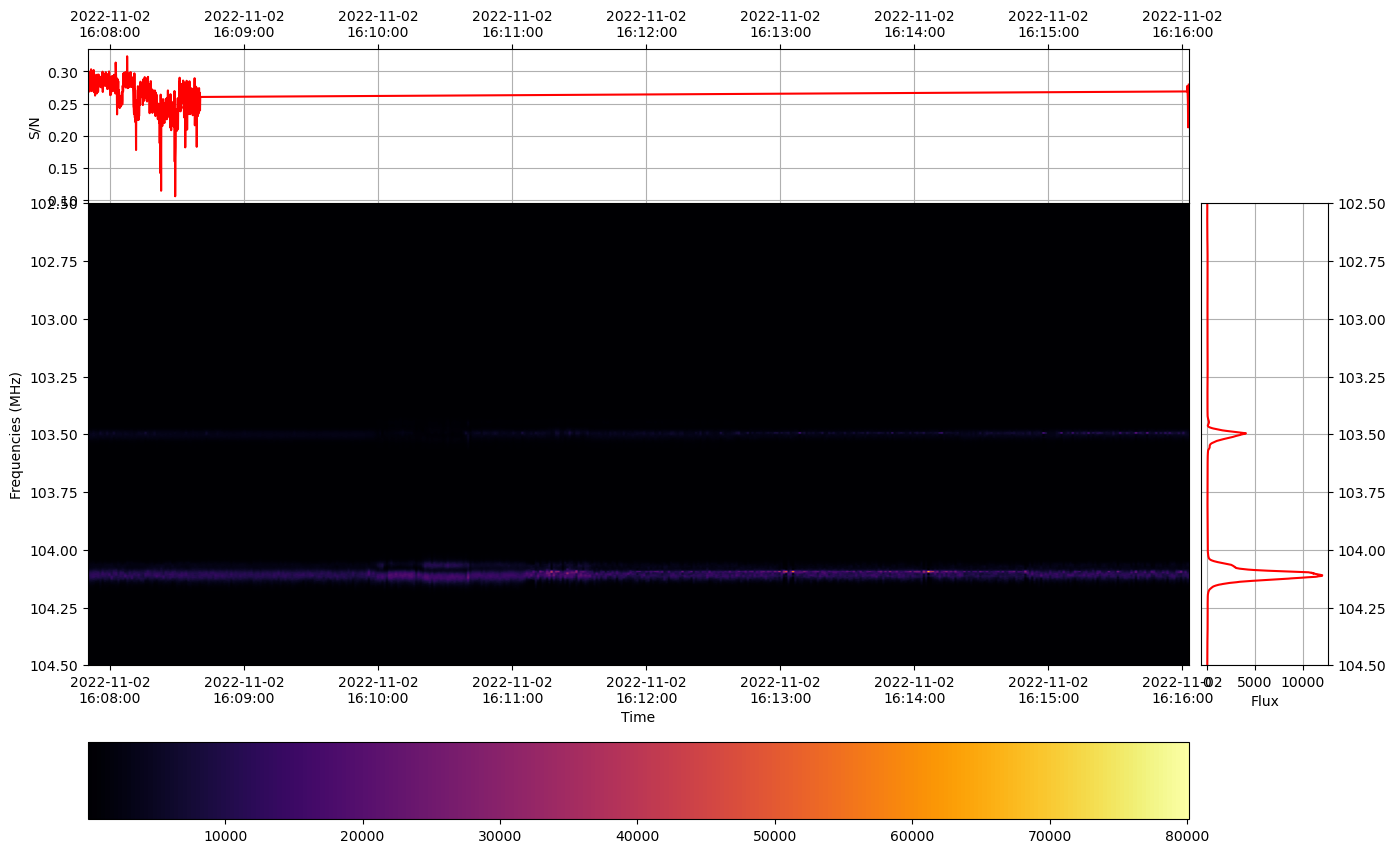

In [5]:
obs.plot_waterfall(obs.data);

In [6]:
df_cal, _ = obs.calibrate(data=obs.data, T_rx=300, scale=1000, flux=True)
df_rfi, _, _ = RFI_filter(df_cal, threshold=3, window=100)

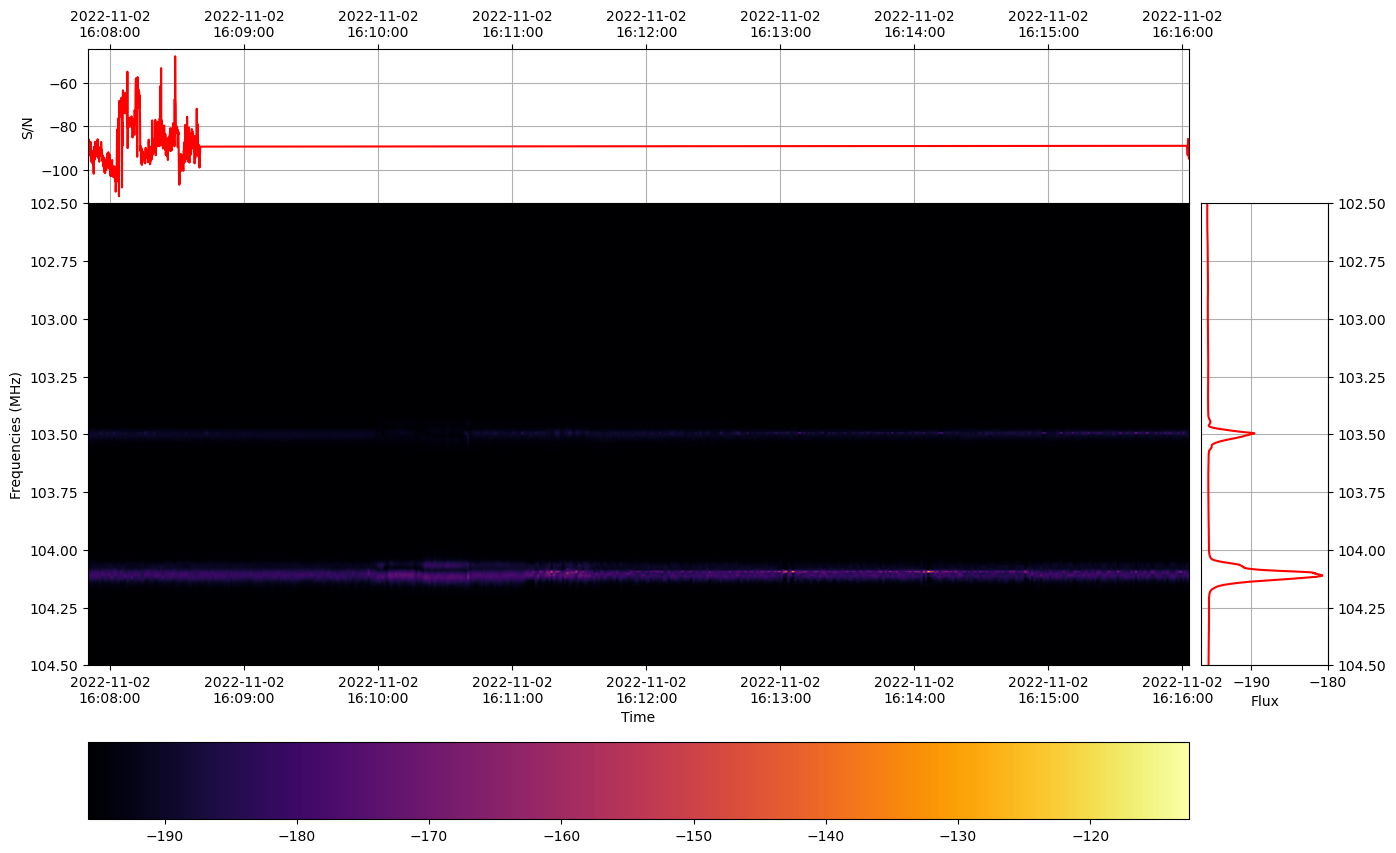

In [7]:
obs.plot_waterfall(df_cal);

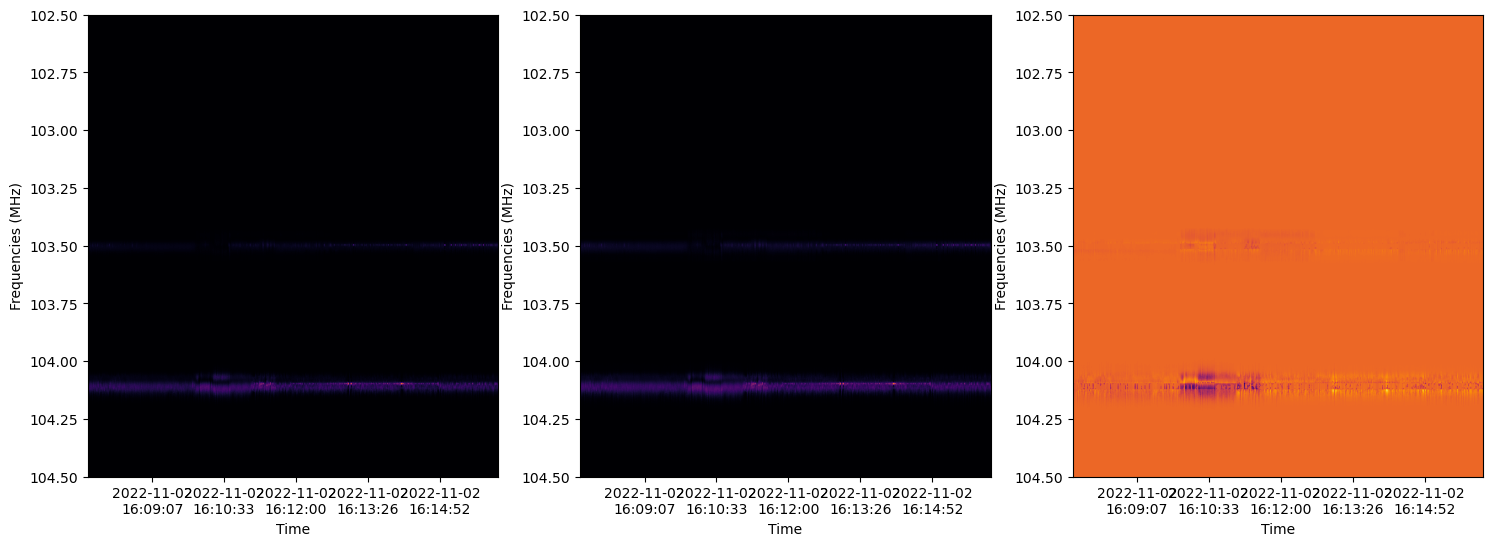

In [8]:
plot_mosaic([obs.data, df_cal, df_rfi]);

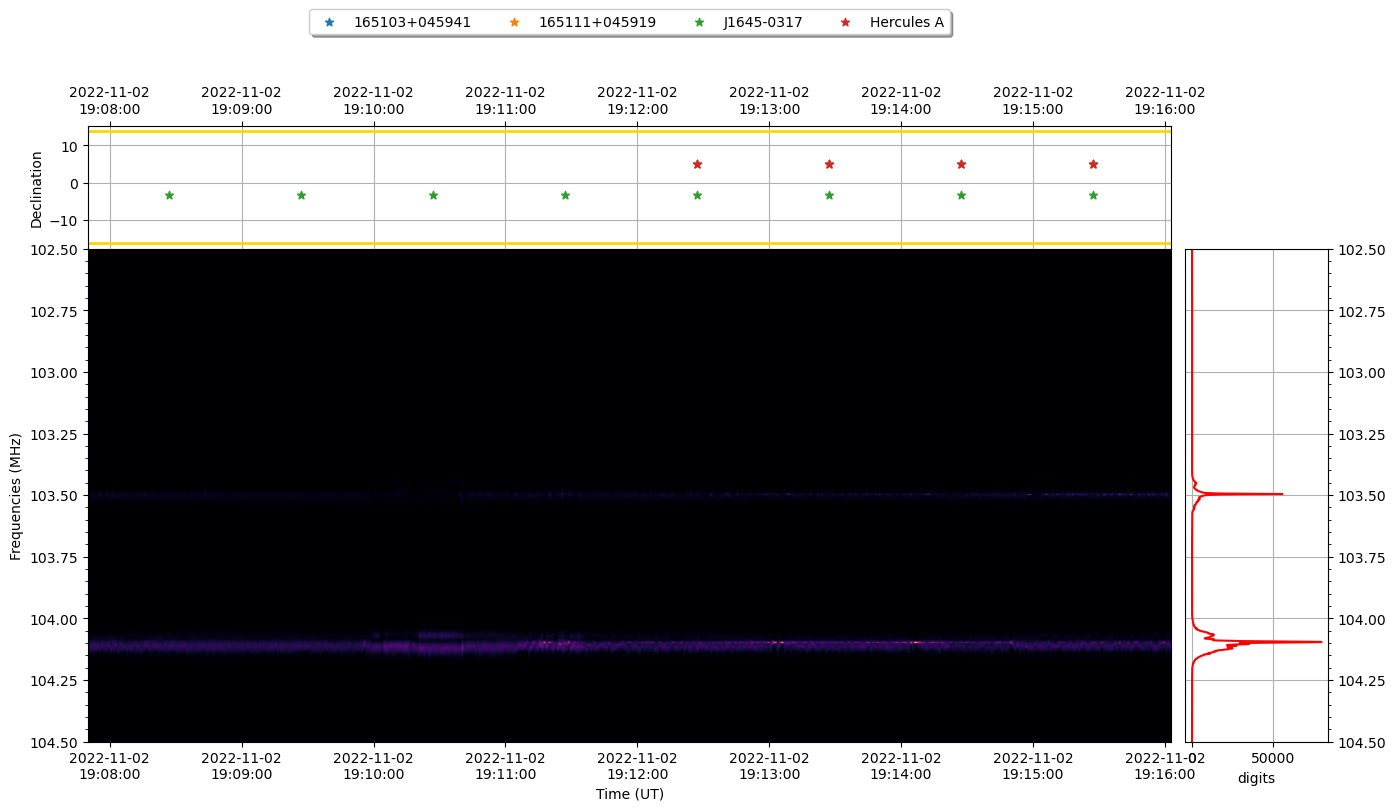

In [9]:
obs.make_sky().sky.plot_timeseries(obs.data);